In [1]:
import os
from collections import Counter
from pathlib import Path

import anndata
import altair as alt
import pandas as pd
import numpy as np
import scipy
import scanpy as sc
import seaborn as sns
import umap
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler


import mgitools.os_helpers as os_helpers

In [2]:
from pollock.models.model import predict_from_anndata, embed_from_anndata
from pollock.models.explain import explain_predictions

In [3]:
DATA_DIR = '../benchmarking/sandbox/figure_data'
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

###### train model if needed

In [4]:
adata = sc.read_h5ad('/home/estorrs/data/single_cell_classification/tumor/BR/scRNA/brca_with_immune.h5ad')

In [5]:
# adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, n_top_genes=3000)
# adata.raw = adata
# adata = adata[:, adata.var.highly_variable]
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# sc.pp.scale(adata, max_value=10)

In [6]:
# sc.tl.pca(adata, svd_solver='arpack')
# sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
# sc.tl.umap(adata)

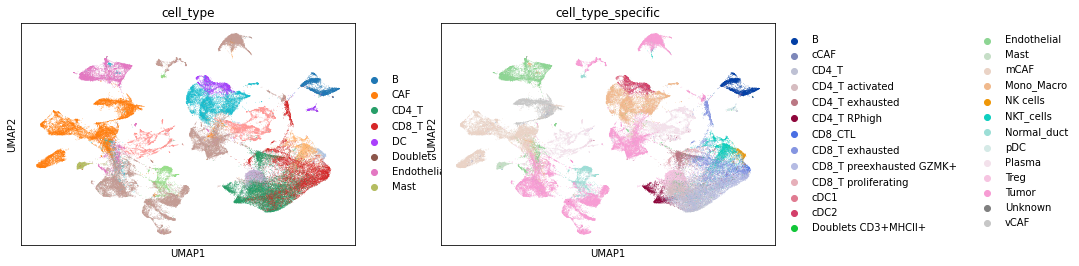

In [7]:
sc.pl.umap(adata, color=['cell_type', 'cell_type_specific'])

In [8]:
cell_type_map = {
    'B': 'B cell',
    'CD4_T': 'CD4 T cell',
    'CD4_T activated': 'CD4 T cell - activated',
    'CD4_T exhausted': 'CD4 T cell - exhausted',
    'CD4_T RPhigh': 'CD4 T cell - RP-high',
    'CD8_CTL': 'CD8 T cell - CTL',
    'CD8_T exhausted': 'CD8 T cell - exhausted',
    'CD8_T preexhausted GZMK+': 'CD8 T cell - preexhausted',
    'CD8_T proliferating': 'CD8 T cell - proliferating',
    'cDC1': 'cDC1',
    'cDC2': 'cDC2',
    'Mast': 'Mast',
    'Mono_Macro': 'Monocyte/Macrophage',
    'NK_cells': 'NK',
    'NKT_cells': 'NKT',
    'pDC': 'pDC',
    'Plasma': 'Plasma',
    'Treg': 'Treg',
}
immune = adata[[True if c in cell_type_map else False for c in adata.obs['cell_type_specific']]]
immune.obs['cell_type'] = [cell_type_map[c] for c in immune.obs['cell_type_specific']]

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.obs` of view, copying.


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'cell_type' as categorical


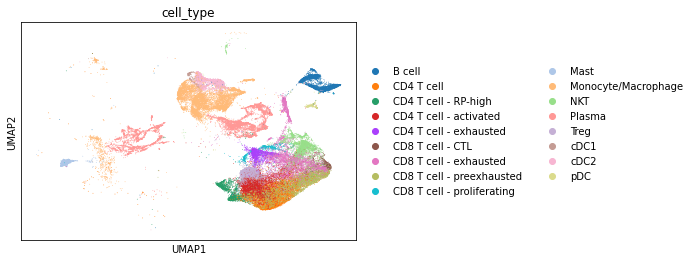

In [9]:
sc.pl.umap(immune, color=['cell_type'])

In [10]:
counts_adata = immune.copy()
counts_adata.X = counts_adata.layers['counts']
counts_adata

AnnData object with n_obs × n_vars = 50882 × 27131
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'sample', 'tissue_type', 'cell_type', 'cell_type_specific', 'Piece_ID', 'Clinical_Subtype', 'doublet_score', 'predicted_doublet', 'Composite_PAM50', 'active.ident'
    uns: 'cell_type_colors', 'cell_type_specific_colors'
    obsm: 'X_umap'
    layers: 'counts'

In [11]:
set(counts_adata.X[0].toarray().flatten())

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 31.0,
 32.0,
 35.0,
 36.0,
 39.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 56.0,
 73.0,
 93.0,
 118.0,
 410.0}

In [12]:
from collections import Counter
from pollock.models.model import PollockDataset, PollockModel, balancedish_training_generator

In [13]:
Counter(counts_adata.obs['cell_type'])

Counter({'CD8 T cell - CTL': 705,
         'CD8 T cell - preexhausted': 4190,
         'Monocyte/Macrophage': 8049,
         'Treg': 2721,
         'CD4 T cell': 7104,
         'CD8 T cell - exhausted': 4099,
         'cDC2': 2079,
         'NKT': 3328,
         'CD4 T cell - activated': 2745,
         'B cell': 2972,
         'cDC1': 268,
         'CD4 T cell - RP-high': 2346,
         'pDC': 385,
         'Plasma': 7092,
         'Mast': 755,
         'CD8 T cell - proliferating': 529,
         'CD4 T cell - exhausted': 1515})

In [14]:
train, rest = balancedish_training_generator(counts_adata, 'cell_type', n_per_cell_type=1000, split=1.)
train

View of AnnData object with n_obs × n_vars = 14133 × 27131
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'sample', 'tissue_type', 'cell_type', 'cell_type_specific', 'Piece_ID', 'Clinical_Subtype', 'doublet_score', 'predicted_doublet', 'Composite_PAM50', 'active.ident'
    uns: 'cell_type_colors', 'cell_type_specific_colors'
    obsm: 'X_umap'
    layers: 'counts'

In [15]:
## train module
pds = PollockDataset(train.copy(), cell_type_key='cell_type', n_per_cell_type=500,
                    oversample=True, dataset_type='training', )

2021-01-12 12:59:18,564 input dataset shape: (14133, 27131)
2021-01-12 12:59:18,568 possible cell types: ['B cell', 'CD4 T cell', 'CD4 T cell - RP-high', 'CD4 T cell - activated', 'CD4 T cell - exhausted', 'CD8 T cell - CTL', 'CD8 T cell - exhausted', 'CD8 T cell - preexhausted', 'CD8 T cell - proliferating', 'Mast', 'Monocyte/Macrophage', 'NKT', 'Plasma', 'Treg', 'cDC1', 'cDC2', 'pDC']
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [16]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.005, latent_dim=25, )

In [17]:
pm.fit(pds, epochs=20)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 12:59:57,369 epoch: 1, train loss: 24.057178497314453, val loss: 19.480377197265625
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:00:18,664 epoch: 2, train loss: 23.668563842773438, val loss: 19.132614135742188
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:00:39,005 epoch: 3, train loss: 23.487462997436523, val loss: 19.047813415527344
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_d

In [18]:
module_fp = '/home/estorrs/data/single_cell_classification/tumor/BR/scRNA/immune_pollock_module'
pm.save(pds, module_fp)

metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.


Text(32.99999999999999, 0.5, 'Groundtruth')

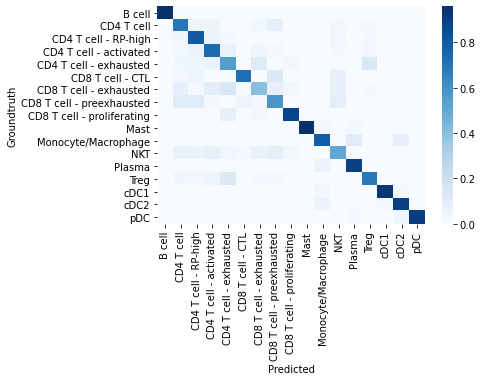

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

In [56]:
# adata = sc.read_h5ad('../benchmarking/data/11302020_harmonized/teir_2/snRNAseq/ccrcc.h5ad')

In [20]:
data_dir = '../benchmarking/data/11302020_harmonized/teir_1/'
fps = sorted(os_helpers.listfiles(data_dir, regex=r'.h5ad'))
fps = [fp for fp in fps if '_val.h5ad' not in fp and '_train.h5ad' not in fp]
fps

['../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/brca.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/cesc.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/hnscc.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/melanoma.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/pbmc.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/pdac.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/brca_gene_activity.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/brca_motif.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/brca_peaks.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/ccrcc_gene_activity.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/ccrcc_motif.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/ccrcc_peaks.h5ad',
 '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/gbm_gene_activity.h5ad

In [21]:
data_map = {}
for fp in fps:
    pieces = fp.split('/')
    dtype = pieces[-2]
    dataset = pieces[-1].replace('.h5ad', '')
    if dtype not in data_map: data_map[dtype] = {}
    data_map[dtype][dataset] = fp
    
d = data_map.pop('snATACseq')
for k, v in d.items():
    disease = v.split('/')[-1].split('_')[0]
    dtype = '_'.join(v.split('/')[-1].replace('.h5ad', '').split('_')[1:])
    
    dtype = f'snATACseq_{dtype}'
    if dtype not in data_map: data_map[dtype] = {}
    data_map[dtype][disease] = v
    
data_map

{'scRNAseq': {'brca': '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/brca.h5ad',
  'cesc': '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/cesc.h5ad',
  'hnscc': '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/hnscc.h5ad',
  'melanoma': '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/melanoma.h5ad',
  'pbmc': '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/pbmc.h5ad',
  'pdac': '../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/pdac.h5ad'},
 'snRNAseq': {'brca': '../benchmarking/data/11302020_harmonized/teir_1/snRNAseq/brca.h5ad',
  'ccrcc': '../benchmarking/data/11302020_harmonized/teir_1/snRNAseq/ccrcc.h5ad',
  'gbm': '../benchmarking/data/11302020_harmonized/teir_1/snRNAseq/gbm.h5ad'},
 'snATACseq_gene_activity': {'brca': '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/brca_gene_activity.h5ad',
  'ccrcc': '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/ccrcc_gene_activity.h5ad',
  'gbm': '../benchmarking

apply model to scRNAseq

In [22]:
data_map.pop('snRNAseq')
data_map.pop('snATACseq_gene_activity')
data_map.pop('snATACseq_motif')
data_map.pop('snATACseq_peaks')

{'brca': '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/brca_peaks.h5ad',
 'ccrcc': '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/ccrcc_peaks.h5ad',
 'gbm': '../benchmarking/data/11302020_harmonized/teir_1/snATACseq/gbm_peaks.h5ad'}

In [23]:
def incorporate_predictions(adata, model_fp):
    preds = predict_from_anndata(adata, model_fp)
    emb = embed_from_anndata(adata, model_fp)

    adata.obs = pd.concat((adata.obs, preds), axis=1)
    adata.obsm['pollock_embedding'] = emb.values
    adata.obsm['pollock_umap'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(emb.values))
    
    return adata

In [24]:
a = sc.read_h5ad('../benchmarking/data/11302020_harmonized/teir_1/scRNAseq/brca.h5ad')
set(a.obs['cell_type'])

{'B cell',
 'CD4 T cell',
 'CD8 T cell',
 'Dendritic',
 'Endothelial',
 'Erythrocyte',
 'Fibroblast',
 'Malignant',
 'Mast',
 'Monocyte',
 'NK',
 'Plasma',
 'Treg'}

In [25]:
for dtype, d in data_map.items():
    for disease, fp in d.items():
        print(dtype, disease)
        adata = sc.read_h5ad(fp)
        adata.obs.columns = adata.obs.columns.astype(str)
        adata.var.columns = adata.var.columns.astype(str)
        
#         # lets keep only t cells
#         keep = {'CD4 T cell', 'CD8 T cell', 'Treg'}
#         adata = adata[[True if c in keep else False for c in adata.obs['cell_type']]]
        
        data_map[dtype][disease] = incorporate_predictions(adata, module_fp)

scRNAseq brca


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:10:11,704 0 genes in training set are missing from prediction set
2021-01-12 13:10:12,212 starting batch 1 of 10
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:10:12,450 0 genes in training set are missing from prediction set
2021-01-12 13:10:37,031 starting batch 2 of 10
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:10:37,347 0 genes in training set are missing from prediction set
2021-01-12 13:11:00,764 starting batch 3 of 10
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:11:01,249 0 genes in training set are missing from prediction set
2021-01-12 13:11:25,138 starting batch 4 of 10
is_categorical is deprecated and will be removed in a future version.  Use i

scRNAseq cesc


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:19:22,221 4469 genes in training set are missing from prediction set
2021-01-12 13:19:22,730 starting batch 1 of 4
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:19:23,228 4469 genes in training set are missing from prediction set
2021-01-12 13:19:54,280 starting batch 2 of 4
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:19:54,646 4469 genes in training set are missing from prediction set
2021-01-12 13:20:27,096 starting batch 3 of 4
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:20:27,536 4469 genes in training set are missing from prediction set
2021-01-12 13:21:04,196 starting batch 4 of 4
is_categorical is deprecated and will be removed in a future version

scRNAseq hnscc


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:23:36,078 1308 genes in training set are missing from prediction set
2021-01-12 13:23:36,570 starting batch 1 of 23
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:23:36,782 1308 genes in training set are missing from prediction set
2021-01-12 13:24:02,221 starting batch 2 of 23
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:24:02,525 1308 genes in training set are missing from prediction set
2021-01-12 13:24:27,097 starting batch 3 of 23
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:24:27,434 1308 genes in training set are missing from prediction set
2021-01-12 13:24:53,571 starting batch 4 of 23
is_categorical is deprecated and will be removed in a future ver

2021-01-12 13:42:46,758 starting batch 19 of 23
2021-01-12 13:42:47,213 1308 genes in training set are missing from prediction set
2021-01-12 13:43:18,551 starting batch 20 of 23
2021-01-12 13:43:19,096 1308 genes in training set are missing from prediction set
2021-01-12 13:43:46,508 starting batch 21 of 23
2021-01-12 13:43:46,884 1308 genes in training set are missing from prediction set
2021-01-12 13:44:14,930 starting batch 22 of 23
2021-01-12 13:44:15,378 1308 genes in training set are missing from prediction set
2021-01-12 13:44:47,921 starting batch 23 of 23
2021-01-12 13:44:48,220 1308 genes in training set are missing from prediction set


scRNAseq melanoma


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:48:13,141 5593 genes in training set are missing from prediction set
2021-01-12 13:48:13,746 starting batch 1 of 6
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:48:13,972 5593 genes in training set are missing from prediction set
2021-01-12 13:48:37,034 starting batch 2 of 6
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:48:37,234 5593 genes in training set are missing from prediction set
2021-01-12 13:49:01,583 starting batch 3 of 6
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:49:01,871 5593 genes in training set are missing from prediction set
2021-01-12 13:49:25,352 starting batch 4 of 6
is_categorical is deprecated and will be removed in a future version

scRNAseq pbmc


2021-01-12 13:53:05,574 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:53:05,674 8620 genes in training set are missing from prediction set
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:53:11,777 8620 genes in training set are missing from prediction set
2021-01-12 13:53:12,395 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:53:12,495 8620 genes in training set are missing from prediction set


scRNAseq pdac


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:53:39,511 298 genes in training set are missing from prediction set
2021-01-12 13:53:39,995 starting batch 1 of 18
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:53:40,339 298 genes in training set are missing from prediction set
2021-01-12 13:54:07,098 starting batch 2 of 18
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:54:07,471 298 genes in training set are missing from prediction set
2021-01-12 13:54:35,212 starting batch 3 of 18
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 13:54:35,773 298 genes in training set are missing from prediction set
2021-01-12 13:55:03,223 starting batch 4 of 18
is_categorical is deprecated and will be removed in a future version

lets look at the predictions

In [26]:
sorted(set(data_map['scRNAseq']['brca'].obs['predicted_cell_type']))

['B cell',
 'CD4 T cell',
 'CD4 T cell - RP-high',
 'CD4 T cell - activated',
 'CD4 T cell - exhausted',
 'CD8 T cell - CTL',
 'CD8 T cell - exhausted',
 'CD8 T cell - preexhausted',
 'CD8 T cell - proliferating',
 'Mast',
 'Monocyte/Macrophage',
 'NKT',
 'Plasma',
 'Treg',
 'cDC1',
 'cDC2',
 'pDC']

scRNAseq_brca


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


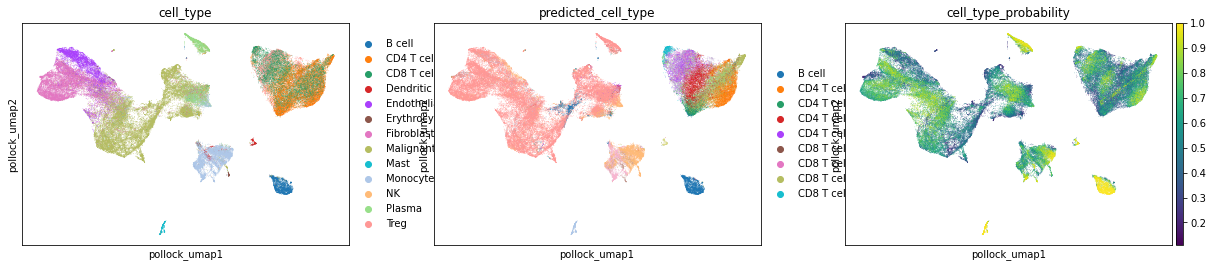

scRNAseq_cesc


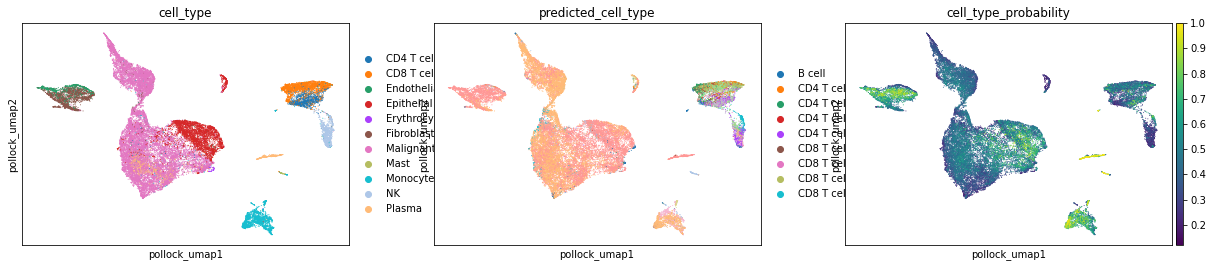

scRNAseq_hnscc


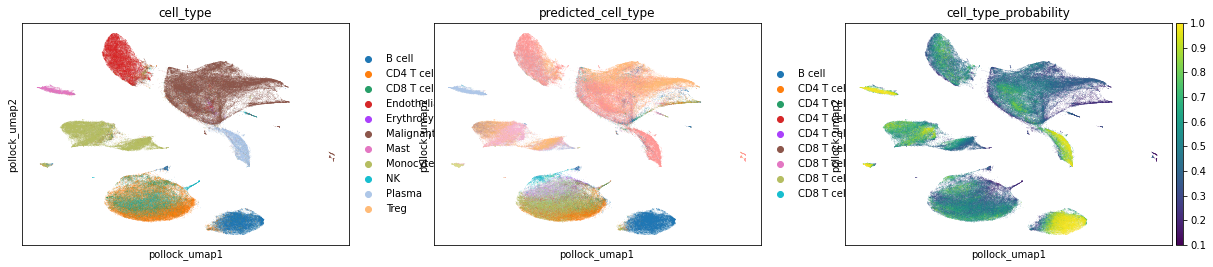

scRNAseq_melanoma


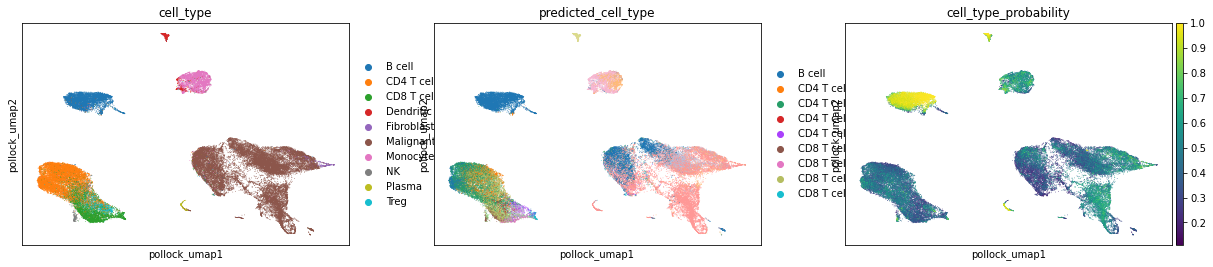

scRNAseq_pbmc


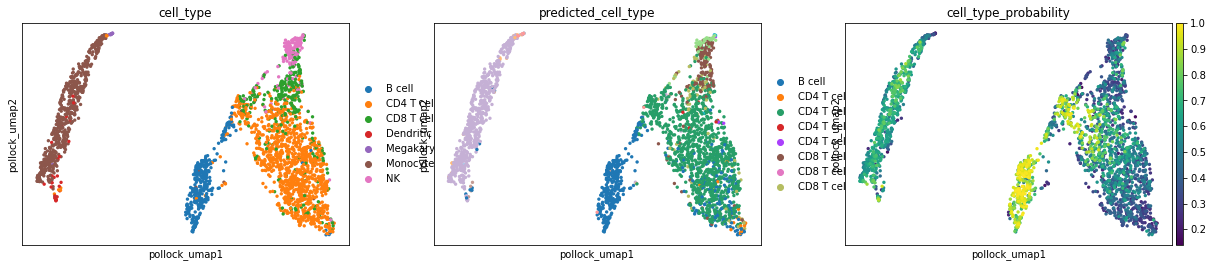

scRNAseq_pdac


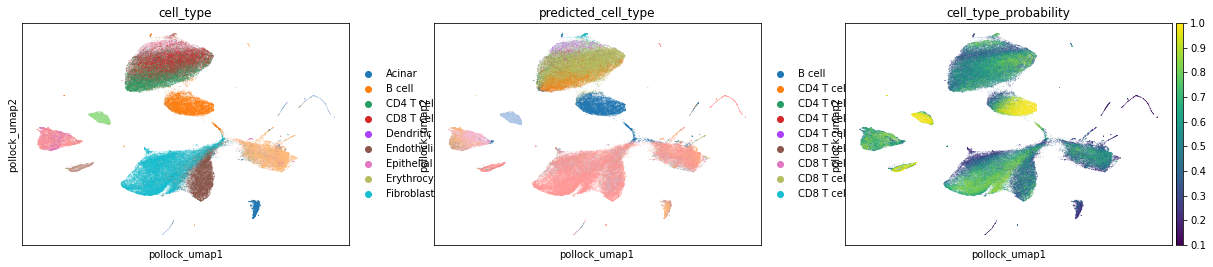

In [28]:
# immune = [
# #     'Basophil',
#  'CD4 CTL',
#  'CD4 T cell',
#  'CD4 T cell activated',
#  'CD4 T cell naive',
#  'CD4/CD8 proliferating',
#  'CD8 CTL',
#  'CD8 T cell preexhausted',
# #  'Macrophage',
# #  'Macrophage proliferating',
#  'NK cell strong',
#  'NK cell weak',
# #  'Plasma',
#  'TRM',
#  'Treg',
# #  'cDC',
# #  'pDC'
# ]
i2 = ['CD4 T cell', 'CD8 T cell', 'NK', 'Treg', 'Monocyte', 'Mast', 'B', 'Dendritic', 'Plasma']
import matplotlib.pyplot as plt
# for dtype, d in data_map.items():
filtered_data_map = {}
for disease, adata in data_map['scRNAseq'].items():
    print(f'{dtype}_{disease}')
    pdf = adata[[True if c in i2 else False for c in adata.obs['cell_type']]]
#     pdf = adata[[True if c in immune else False for c in adata.obs['predicted_cell_type']]]
#     pdf = pdf[[True if c in i2 else False for c in pdf.obs['cell_type']]]
    sc.pl.embedding(adata, basis='pollock_umap', 
            color=['cell_type', 'predicted_cell_type', 'cell_type_probability'], ncols=3)
    filtered_data_map[disease] = pdf
#     plt.title(disease)
    plt.show()

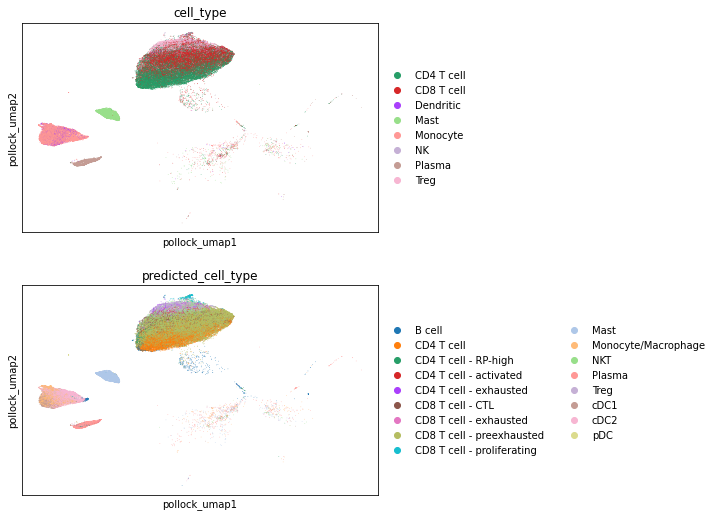

In [30]:
sc.pl.embedding(filtered_data_map['pdac'], basis='pollock_umap',
                color=['cell_type', 'predicted_cell_type'],
               ncols=1)

In [31]:
combined = None
for disease, adata in filtered_data_map.items():
    adata.obs['disease'] = disease
    if combined is None:
        combined = adata
    else:
        combined = anndata.concat((combined, adata))
combined.obs_names_make_unique()
combined

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 269933 × 15902
    obs: 'cell_type', 'predicted_cell_type', 'cell_type_probability', 'probability_B cell', 'probability_CD4 T cell', 'probability_CD4 T cell - RP-high', 'probability_CD4 T cell - activated', 'probability_CD4 T cell - exhausted', 'probability_CD8 T cell - CTL', 'probability_CD8 T cell - exhausted', 'probability_CD8 T cell - preexhausted', 'probability_CD8 T cell - proliferating', 'probability_Mast', 'probability_Monocyte/Macrophage', 'probability_NKT', 'probability_Plasma', 'probability_Treg', 'probability_cDC1', 'probability_cDC2', 'probability_pDC', 'disease'
    obsm: 'pollock_embedding', 'pollock_umap'

In [92]:
# sc.pp.neighbors(combined, use_rep='pollock_embedding')
# sc.tl.umap(combined)

In [32]:
sc.pp.normalize_total(combined, 10000)
sc.pp.log1p(combined)
# sc.pp.scale(combined)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'cell_type' as categorical
... storing 'predicted_cell_type' as categorical
... storing 'disease' as categorical


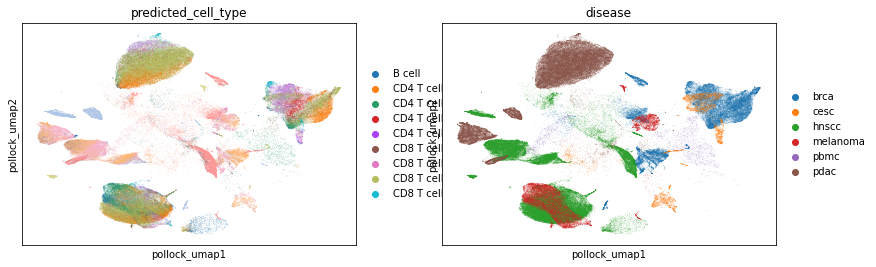

In [33]:
sc.pl.embedding(combined, basis='pollock_umap', color=['predicted_cell_type', 'disease'])

In [34]:
from collections import Counter
def plot_proportion(adata, x, y, percentage=True):
    samples = sorted(set(adata.obs[x]))
    cell_types = sorted(set(adata.obs[y]))

    data = []
    for s in samples:
        mini = adata.obs[adata.obs[x]==s]
        counts = Counter(mini[y])
        for c in cell_types:
            data.append([s, c, counts.get(c, 0)/mini.shape[0] if percentage else counts.get(c, 0)])
    df = pd.DataFrame(data=data)
    df.columns = [x, y, 'fraction' if percentage else 'count']

    return alt.Chart(df).mark_bar().encode(
        x=x,
        y='fraction' if percentage else 'count',
        color=y
    )
plot_proportion(combined, 'disease', 'predicted_cell_type')

alt.Chart(...)

In [35]:
to_explained = {}
from pollock.models.model import balancedish_training_generator
for disease, adata in filtered_data_map.items():
    explain, rest = balancedish_training_generator(adata, cell_type_key='predicted_cell_type',
                                                   n_per_cell_type=50, oversample=False,
                                        split=1.)
    background, _ = balancedish_training_generator(rest, cell_type_key='predicted_cell_type', n_per_cell_type=10,
                                                   oversample=False,
                                               split=1.)
    print(disease, explain.shape)
    w = explain_predictions(explain.copy(), background.copy(), module_fp, prediction_key='predicted_cell_type')
    to_explained[disease] = w


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'disease' as categorical
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'disease' as categorical


brca (850, 27131)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 15:41:02,110 0 genes in training set are missing from prediction set
2021-01-12 15:41:02,674 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 15:41:02,770 0 genes in training set are missing from prediction set
2021-01-12 15:41:06,085 0 genes in training set are missing from prediction set
2021-01-12 15:41:07,993 (850, 27131)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'disease' as categorical
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call 

cesc (850, 22928)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 17:00:53,451 4469 genes in training set are missing from prediction set
2021-01-12 17:00:54,003 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 17:00:54,417 4469 genes in training set are missing from prediction set
2021-01-12 17:00:58,185 4469 genes in training set are missing from prediction set
2021-01-12 17:01:00,171 (850, 27131)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'disease' as categorical
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them uniq

hnscc (850, 26929)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 18:21:57,734 1308 genes in training set are missing from prediction set
2021-01-12 18:21:58,315 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 18:21:58,419 1308 genes in training set are missing from prediction set
2021-01-12 18:22:01,684 1308 genes in training set are missing from prediction set
2021-01-12 18:22:03,070 (850, 27131)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'disease' as categorical
Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them uniq

melanoma (850, 23452)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 19:41:19,802 5593 genes in training set are missing from prediction set
2021-01-12 19:41:20,486 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 19:41:20,618 5593 genes in training set are missing from prediction set
2021-01-12 19:41:24,002 5593 genes in training set are missing from prediction set
2021-01-12 19:41:25,462 (850, 27131)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'disease' as categorical


pbmc (362, 32738)


Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'disease' as categorical
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 20:16:40,503 8620 genes in training set are missing from prediction set
2021-01-12 20:16:41,082 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 20:16:41,193 8620 genes in training set are missing from prediction set
2021-01-12 20:16:42,757 8620 genes in training set are missing from prediction set
2021-01-12 20:16:44,087 (362, 27131)
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.

pdac (844, 28756)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 21:34:40,506 298 genes in training set are missing from prediction set
2021-01-12 21:34:41,075 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2021-01-12 21:34:41,195 298 genes in training set are missing from prediction set
2021-01-12 21:34:44,484 298 genes in training set are missing from prediction set
2021-01-12 21:34:45,785 (844, 27131)


In [36]:
to_explained.keys()

dict_keys(['brca', 'cesc', 'hnscc', 'melanoma', 'pbmc', 'pdac'])

In [37]:
to_explained['brca']

,AL627309.1,AL627309.3,AL627309.4,AL732372.1,AL669831.2,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.7,...,MAFIP,AC011043.1,AL592183.1,AC007325.4,AC007325.2,AL354822.1,AC004556.1,AC233755.2,AC233755.1,AC240274.1
cell_id,,,,,,,,,,,,,,,,,,,,,
_HT062B1_S1PA_AATAGAGAGCGTGCTC-1,0.0,0.0,0.0,0.0,0.0,5.451469e-05,0.0,2.970257e-05,1.311652e-05,0.0,...,2.012451e-05,0.0,0.000003,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
_HT062B1_S1PA_AATCACGGTAGTCCTA-1,0.0,0.0,0.0,0.0,0.0,1.060134e-05,0.0,6.862803e-06,3.482701e-06,0.0,...,1.391825e-06,0.0,0.000015,0.0,0.0,0.0,0.000010,0.0,0.0,0.0
_HT062B1_S1PA_AATCACGTCGTCTCAC-1,0.0,0.0,0.0,0.0,0.0,1.617938e-05,0.0,1.694957e-05,0.000000e+00,0.0,...,2.043492e-05,0.0,0.000001,0.0,0.0,0.0,0.000001,0.0,0.0,0.0
_HT062B1_S1PA_ATCACGAAGCGTATGG-1,0.0,0.0,0.0,0.0,0.0,1.118996e-05,0.0,3.687794e-05,2.009181e-05,0.0,...,2.187453e-05,0.0,0.000023,0.0,0.0,0.0,0.000105,0.0,0.0,0.0
_HT062B1_S1PA_ATCGGCGAGCTAATGA-1,0.0,0.0,0.0,0.0,0.0,1.537048e-05,0.0,2.836012e-07,4.740903e-06,0.0,...,2.118031e-07,0.0,0.000003,0.0,0.0,0.0,0.000026,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_HT171B1_BC2_TTTCACAGTCCTTGTC-1,0.0,0.0,0.0,0.0,0.0,9.993769e-07,0.0,2.493590e-05,8.835668e-07,0.0,...,0.000000e+00,0.0,0.000010,0.0,0.0,0.0,0.000002,0.0,0.0,0.0
_HT171B1_BC2_TTTCATGGTCAAAGTA-1,0.0,0.0,0.0,0.0,0.0,7.611484e-06,0.0,2.285149e-05,0.000000e+00,0.0,...,2.715160e-05,0.0,0.000025,0.0,0.0,0.0,0.000073,0.0,0.0,0.0
_HT171B1_BC2_TTTGGAGGTTGTGGAG-1,0.0,0.0,0.0,0.0,0.0,5.878382e-07,0.0,1.685381e-05,8.331499e-06,0.0,...,9.767425e-07,0.0,0.000000,0.0,0.0,0.0,0.000001,0.0,0.0,0.0


In [38]:
import anndata

In [50]:
explain = None
adatas = []
for k, df in to_explained.items():
    og = filtered_data_map[k]
    og = og[df.index].copy()
    new = anndata.AnnData(X=df.values, obs=og.obs)
    new.var.index = df.columns
    new.obs['disease'] = k
    adatas.append(new)
    
    feature_adata = new.copy()

    sc.pp.scale(feature_adata)
    
    if explain is None:
        explain = feature_adata
    else:
        explain = anndata.concat((explain, feature_adata))

explain
    

AnnData object with n_obs × n_vars = 4606 × 27131
    obs: 'cell_type', 'predicted_cell_type', 'cell_type_probability', 'probability_B cell', 'probability_CD4 T cell', 'probability_CD4 T cell - RP-high', 'probability_CD4 T cell - activated', 'probability_CD4 T cell - exhausted', 'probability_CD8 T cell - CTL', 'probability_CD8 T cell - exhausted', 'probability_CD8 T cell - preexhausted', 'probability_CD8 T cell - proliferating', 'probability_Mast', 'probability_Monocyte/Macrophage', 'probability_NKT', 'probability_Plasma', 'probability_Treg', 'probability_cDC1', 'probability_cDC2', 'probability_pDC', 'disease'

In [40]:
explain.write_h5ad(os.path.join(DATA_DIR, 'explain_panimmune_breast_module.h5ad'))

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'cell_type' as categorical
... storing 'predicted_cell_type' as categorical
... storing 'disease' as categorical


In [110]:
for adata in adatas: adata.obs['ingest_label'] = adata.obs['predicted_cell_type'].to_list()
main = adatas[0].copy()
# sc.pp.scale(main)
sc.pp.neighbors(main)
sc.pp.pca(main)
sc.tl.umap(main)

ls = [main]
for adata in adatas[1:]:
    ls.append(sc.tl.ingest(adata.copy(), main, obs='ingest_label', inplace=False))

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [111]:
main = anndata.concat(ls)
main

AnnData object with n_obs × n_vars = 274 × 60725
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'sample', 'tissue_type', 'cell_type', 'cell_type_specific', 'Piece_ID', 'Clinical_Subtype', 'Bulk_PAM50', 'doublet_score', 'predicted_doublet', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_CD4/CD8 Proliferating', 'probability_CD4_act', 'probability_CD4_rest', 'probability_CD8_act', 'probability_CD8_rest', 'probability_Treg', 'disease', 'ingest_label'
    obsm: 'X_pca', 'X_umap'

In [51]:
feature_adata = explain.copy()

# sc.pp.scale(feature_adata)
sc.pp.neighbors(feature_adata)
sc.pp.pca(feature_adata)

sc.tl.umap(feature_adata)
sc.tl.leiden(feature_adata, resolution=1.)
feature_adata

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 4606 × 27131
    obs: 'cell_type', 'predicted_cell_type', 'cell_type_probability', 'probability_B cell', 'probability_CD4 T cell', 'probability_CD4 T cell - RP-high', 'probability_CD4 T cell - activated', 'probability_CD4 T cell - exhausted', 'probability_CD8 T cell - CTL', 'probability_CD8 T cell - exhausted', 'probability_CD8 T cell - preexhausted', 'probability_CD8 T cell - proliferating', 'probability_Mast', 'probability_Monocyte/Macrophage', 'probability_NKT', 'probability_Plasma', 'probability_Treg', 'probability_cDC1', 'probability_cDC2', 'probability_pDC', 'disease', 'leiden'
    uns: 'neighbors', 'pca', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

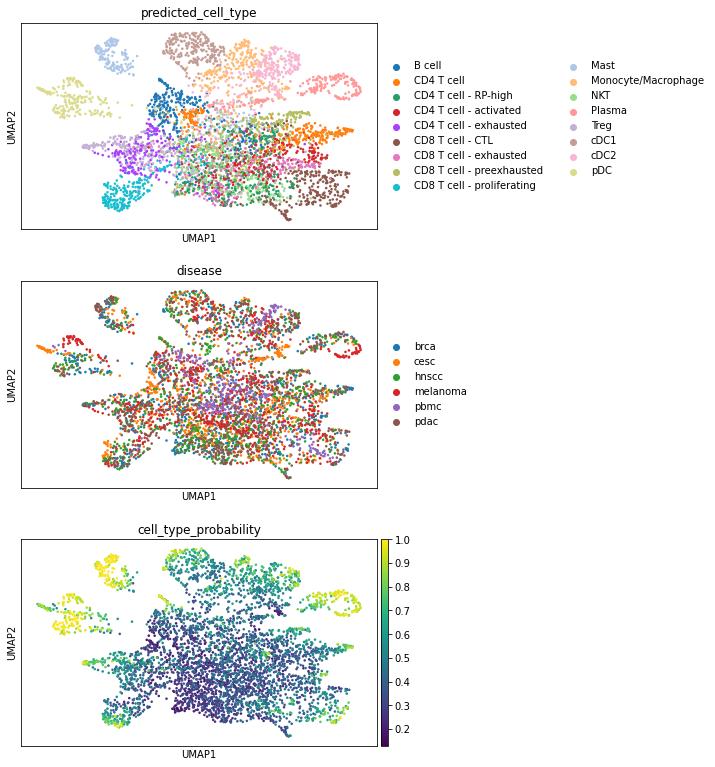

In [65]:
sc.pl.umap(feature_adata, color=['predicted_cell_type', 'disease', 'cell_type_probability'], ncols=1)

In [60]:
marker_genes = {
    'B cell': ['MS4A1'],
    'T cell': ['CD3G', 'CD3D', 'CD8A'],
#     'Memory': [''],
    'Activated': ['CD69', 'CD28'],
    'Naive': ['IL7R'],
    'Effector': ['GZMA'],
    'Memory': ['CX3CR1'],
    'Regulatory': ['FOXP3'],
    'Exausted': ['PDCD1'],
    'Proliferating': ['MKI67', 'TOP2A'],
#     'nk': ['GNLY'],
#     'nk strong': ['FCGR3A', 'SPON2', 'KLRF1'],
    'NK': ['GNLY', 'CD7'],
    'NK - Strong': ['NKG7'],
    'NK - Weak': ['NCAM1'],
    'Mast': ['FCER1A'],
    'Macrophage': ['CD14', 'FCGR3A', 'LYZ'],
    'cDC': ['BATF3','IDO1'],
    'pDC': ['IL3RA'],
    'Plasma': ['SDC1'],
#     'Endothelial': ['PECAM1'],
#     'Fibroblast': ['COL1A1',
# 'SFRP2',
# 'COL3A1',
# 'COL5A1',
# 'COL12A1',
# 'EMILIN1',
# 'LUM',
# 'MMP2',
# 'TNC',
# 'S100A4'],
#     'Malignant': ['CDKN2A',
# 'CDKN2B',
# 'PTEN',
# 'PDGFRA',
# 'EGFR',
# 'ATRX',
# 'PIK3CA',
# 'TERT',
# 'MET'],
    
}

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


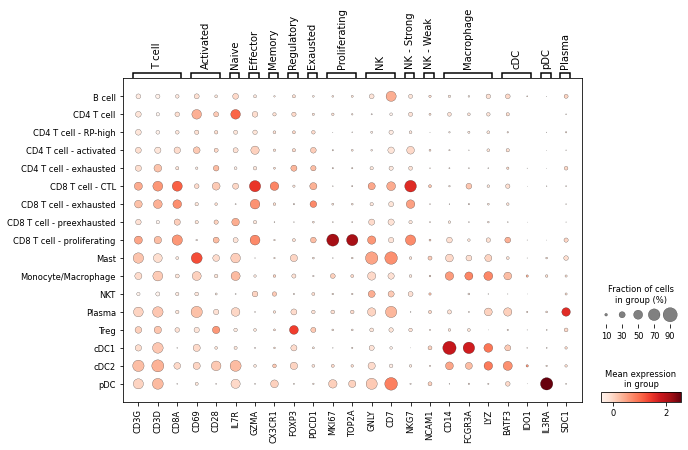

In [53]:
sc.pl.dotplot(feature_adata, marker_genes, groupby='predicted_cell_type')

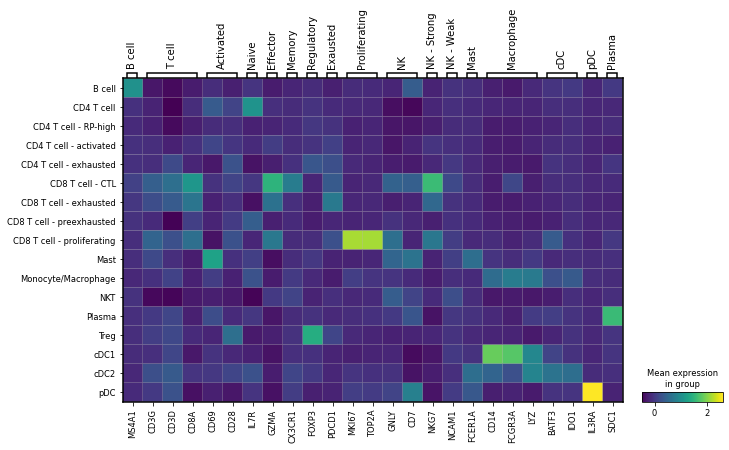

In [61]:
sc.pl.matrixplot(feature_adata, marker_genes, groupby='predicted_cell_type')

B cell


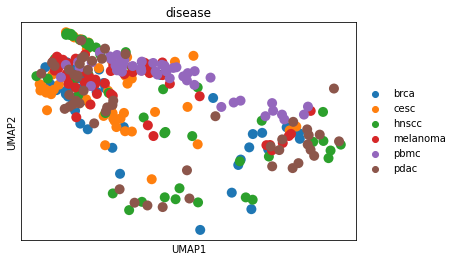

CD4 T cell


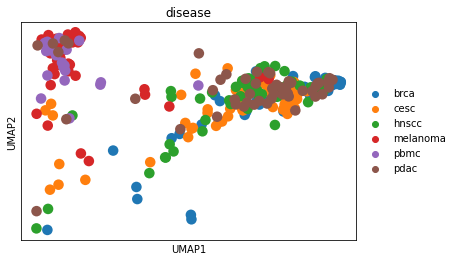

CD4 T cell - RP-high


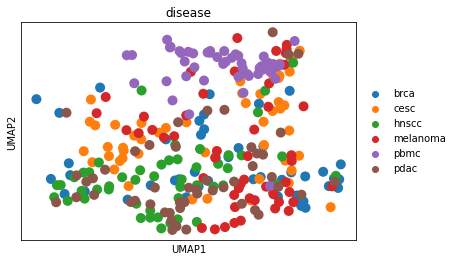

CD4 T cell - activated


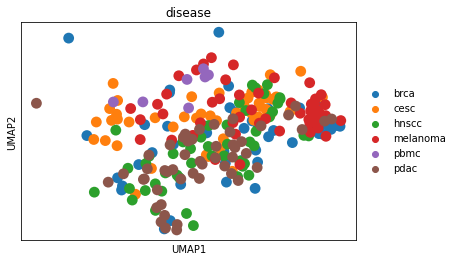

CD4 T cell - exhausted


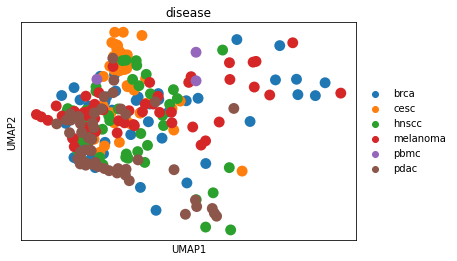

CD8 T cell - CTL


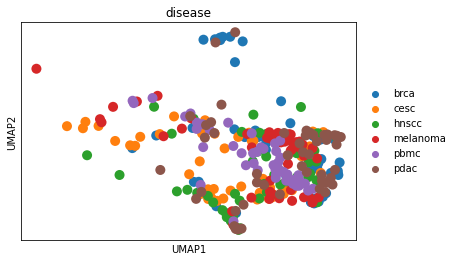

CD8 T cell - exhausted


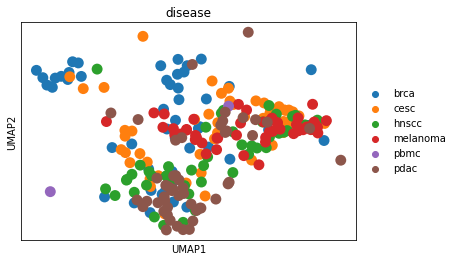

CD8 T cell - preexhausted


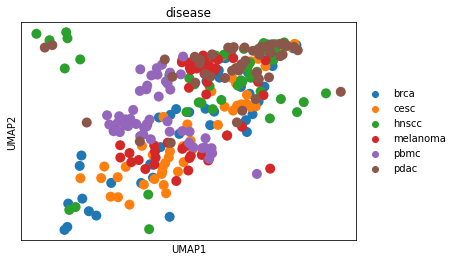

CD8 T cell - proliferating


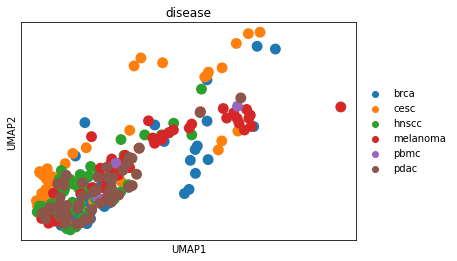

Mast


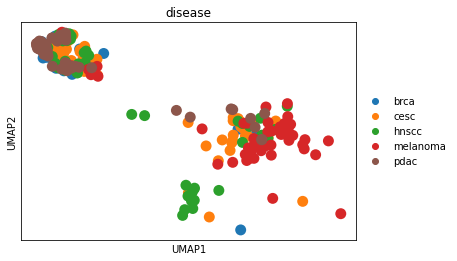

Monocyte/Macrophage


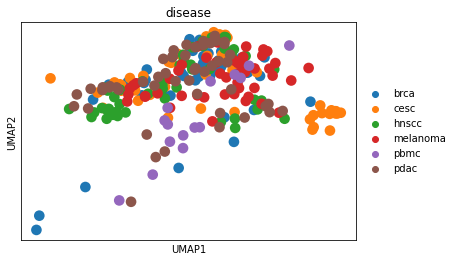

NKT


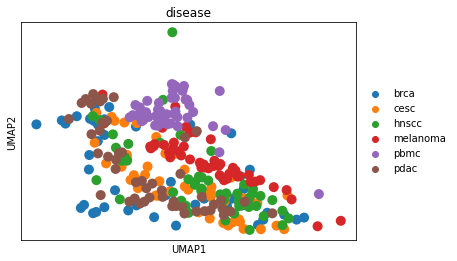

Plasma


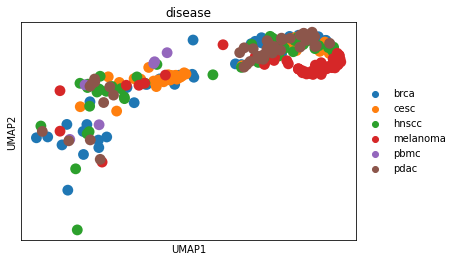

Treg


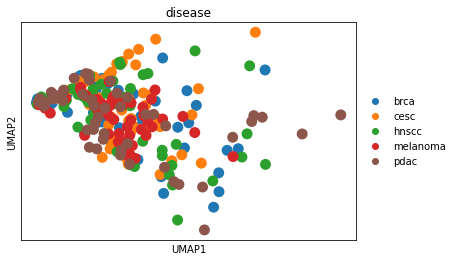

cDC1


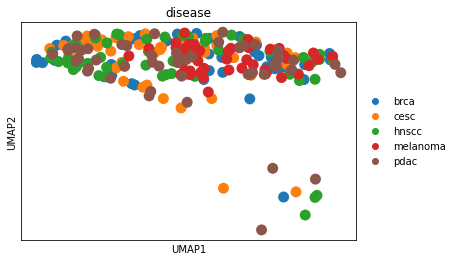

cDC2


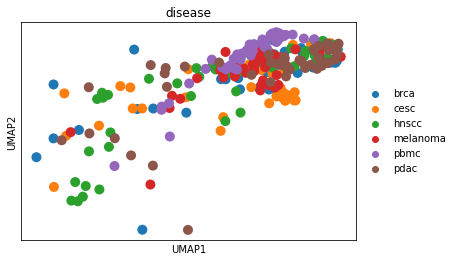

pDC


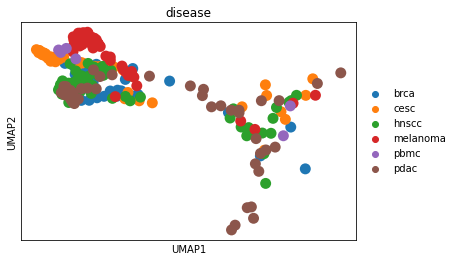

In [64]:
for ct in sorted(set(feature_adata.obs['predicted_cell_type'])):
    print(ct)
    sc.pl.umap(feature_adata[feature_adata.obs['predicted_cell_type']==ct], color='disease')
    plt.show()

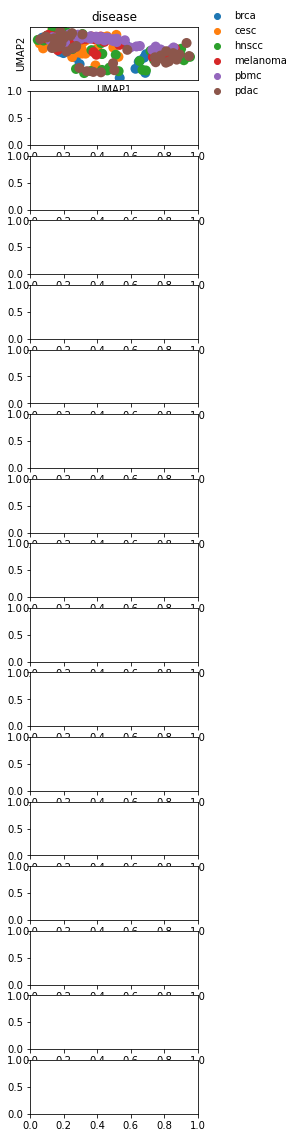

In [96]:
cts = sorted(set(feature_adata.obs['predicted_cell_type']))
fig, axs = plt.subplots(nrows=len(cts), figsize=(3, 20))
for i, ct in enumerate(cts):
#     print(ct)
    axs[i].set_title(ct)
    sc.pl.umap(feature_adata[feature_adata.obs['predicted_cell_type']==ct], color='disease', ax=axs[i])
    

In [90]:
target = feature_adata[feature_adata.obs['predicted_cell_type']=='Plasma'].copy()
# recluster 
sc.pp.neighbors(target)
sc.pp.pca(target)

sc.tl.umap(target)
sc.tl.leiden(target, resolution=.2)
target

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


AnnData object with n_obs × n_vars = 256 × 27131
    obs: 'cell_type', 'predicted_cell_type', 'cell_type_probability', 'probability_B cell', 'probability_CD4 T cell', 'probability_CD4 T cell - RP-high', 'probability_CD4 T cell - activated', 'probability_CD4 T cell - exhausted', 'probability_CD8 T cell - CTL', 'probability_CD8 T cell - exhausted', 'probability_CD8 T cell - preexhausted', 'probability_CD8 T cell - proliferating', 'probability_Mast', 'probability_Monocyte/Macrophage', 'probability_NKT', 'probability_Plasma', 'probability_Treg', 'probability_cDC1', 'probability_cDC2', 'probability_pDC', 'disease', 'leiden'
    uns: 'neighbors', 'pca', 'umap', 'leiden', 'predicted_cell_type_colors', 'disease_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

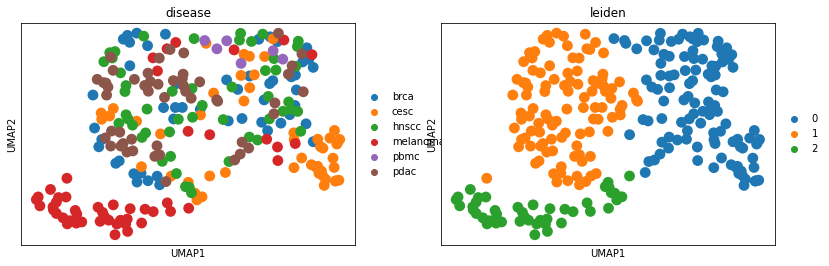

In [91]:
sc.pl.umap(target, color=['disease', 'leiden'])

... storing 'cluster' as categorical


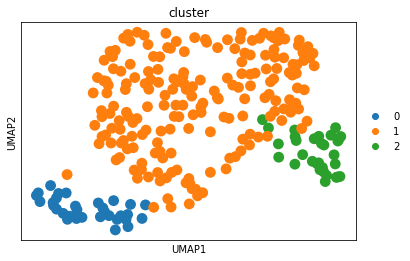

In [72]:
c2c = {
    '0': ['2'],
    '1': ['0', '1', '3', '5', '6', '7'],
    '2': ['4']
}
c2c = {v:k for k, vs in c2c.items() for v in vs}
target.obs['cluster'] = [c2c[c] for c in target.obs['leiden']]
sc.pl.umap(target, color='cluster')

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'cluster' as categorical
invalid value encountered in log2
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


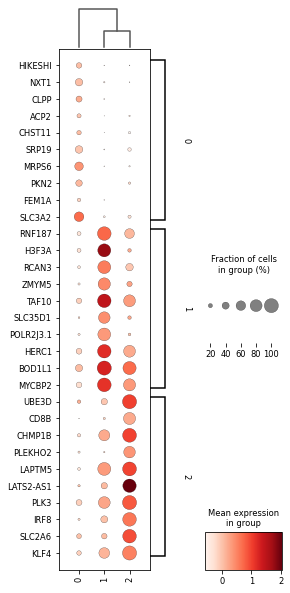

In [100]:
target.obs['cluster']=target.obs['leiden'].to_list()
sc.tl.rank_genes_groups(target, groupby='cluster', method='wilcoxon', )
sc.pl.rank_genes_groups_dotplot(target, swap_axes=True, figsize=(4, 10))

In [ ]:
sc.pl.dotplot()

In [46]:
small = explain[explain.obs['disease']=='brca'].copy()

sc.pp.scale(small)
sc.pp.neighbors(small)
sc.pp.pca(small)

sc.tl.umap(small)
sc.tl.leiden(small, resolution=1.)
small

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 850 × 27131
    obs: 'cell_type', 'predicted_cell_type', 'cell_type_probability', 'probability_B cell', 'probability_CD4 T cell', 'probability_CD4 T cell - RP-high', 'probability_CD4 T cell - activated', 'probability_CD4 T cell - exhausted', 'probability_CD8 T cell - CTL', 'probability_CD8 T cell - exhausted', 'probability_CD8 T cell - preexhausted', 'probability_CD8 T cell - proliferating', 'probability_Mast', 'probability_Monocyte/Macrophage', 'probability_NKT', 'probability_Plasma', 'probability_Treg', 'probability_cDC1', 'probability_cDC2', 'probability_pDC', 'disease', 'leiden'
    var: 'mean', 'std'
    uns: 'neighbors', 'pca', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


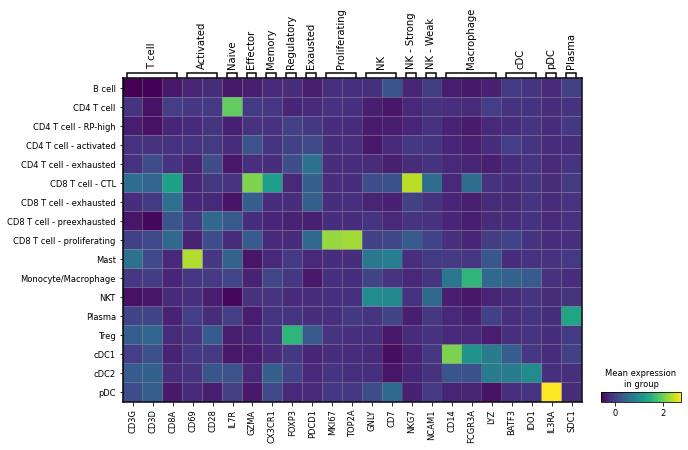

In [49]:
sc.pl.matrixplot(small, marker_genes, groupby='predicted_cell_type')

In [48]:
set(adata.obs['cell_type'])

{'CD4 T cell',
 'CD8 T cell',
 'Dendritic',
 'Mast',
 'Monocyte',
 'NK',
 'Plasma',
 'Treg'}